In [283]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [284]:
def create_captcha(text, shear=0, size=(100, 26)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Sports World-Regular.otf", 18)
    text = " ".join(text)
    draw.text((2,2), text, fill=1,font=font)
    image = np.array(im)
    affine_tn = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tn)
    return image / image.max()

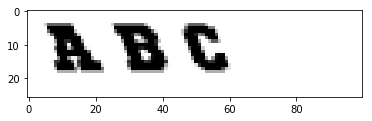

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline
image = create_captcha("ABC", shear=0.4)
plt.imshow(image, cmap='Greys')

In [286]:
from skimage.measure import label, regionprops
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if(len(subimages) == 0):
        return [image,]
    return subimages

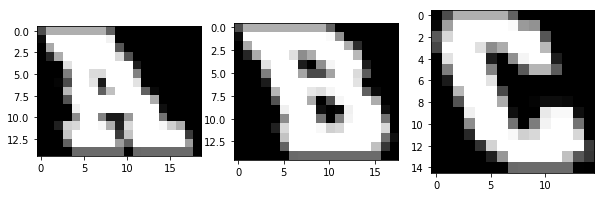

In [287]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
#print(len(subimages))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap='gray')

In [288]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [289]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20,20)), letters.index(letter)

The target for this image is: 11


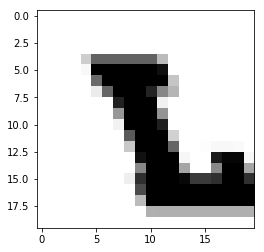

In [290]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap='Greys')
print("The target for this image is: {0}".format(target))

In [291]:
dataset, target = zip(*(generate_sample(random_state) for i in range(3000)))
dataset = np.array(dataset, dtype='float')
target = np.array(target)
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(target.reshape(target.shape[0],1))
y = y.todense()

In [292]:
from skimage.transform import resize
dataset = np.array([resize(segment_image(sample)[0], (20,20)) for sample in dataset])
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [293]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [294]:
from pybrain.datasets import SupervisedDataSet

In [295]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

In [296]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [297]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01, weightdecay=0.01)
trainer.trainEpochs(epochs=55)

In [310]:
predictions = trainer.testOnClassData(dataset=testing)

In [311]:
from sklearn.metrics import f1_score
print("F1 Score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1),  average='weighted' )))

F1 Score: 0.98


In [312]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = neural_network.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [313]:
word = "GENE"
captcha = create_captcha(word, shear=0.3)
print(predict_captcha(captcha, net))

GENE


In [314]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [315]:
from nltk.corpus import words


In [316]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]
#print(valid_words)
num_correct = 0
w = []
a = []
num_incorrect = 0
for word in valid_words:
    correct, word_, prediction = test_prediction(word,net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
# print(a)
# print(w)
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 5054
Number incorrect is 459


In [337]:
c = (np.argmax(y_test, axis=1))
predictions

[13,
 8,
 13,
 1,
 1,
 1,
 25,
 7,
 11,
 7,
 14,
 14,
 23,
 18,
 19,
 6,
 13,
 5,
 3,
 10,
 0,
 6,
 18,
 20,
 15,
 12,
 23,
 23,
 25,
 9,
 8,
 17,
 0,
 3,
 13,
 13,
 8,
 8,
 11,
 14,
 5,
 15,
 17,
 15,
 13,
 7,
 25,
 2,
 6,
 22,
 16,
 11,
 11,
 13,
 14,
 9,
 22,
 16,
 15,
 1,
 6,
 0,
 17,
 20,
 19,
 21,
 21,
 7,
 7,
 5,
 0,
 3,
 2,
 5,
 13,
 18,
 11,
 17,
 14,
 5,
 23,
 1,
 22,
 10,
 15,
 18,
 5,
 25,
 0,
 8,
 6,
 10,
 10,
 5,
 12,
 10,
 6,
 11,
 11,
 1,
 16,
 12,
 18,
 6,
 18,
 19,
 14,
 23,
 4,
 14,
 19,
 22,
 13,
 13,
 20,
 2,
 16,
 6,
 7,
 8,
 16,
 0,
 13,
 2,
 24,
 7,
 9,
 23,
 3,
 2,
 24,
 13,
 25,
 20,
 7,
 15,
 6,
 3,
 5,
 4,
 8,
 12,
 23,
 1,
 16,
 14,
 0,
 21,
 10,
 9,
 3,
 2,
 11,
 22,
 7,
 2,
 12,
 18,
 8,
 17,
 23,
 3,
 24,
 7,
 6,
 9,
 23,
 13,
 15,
 4,
 16,
 12,
 16,
 18,
 6,
 7,
 7,
 8,
 4,
 21,
 13,
 5,
 12,
 5,
 11,
 16,
 25,
 7,
 14,
 16,
 14,
 16,
 18,
 24,
 9,
 12,
 11,
 7,
 9,
 5,
 13,
 17,
 16,
 0,
 25,
 13,
 17,
 9,
 3,
 24,
 17,
 11,
 16,
 19,
 9,
 21,
 0,
 5,


In [336]:
y_final = []
c = np.asarray(c)
for i in c:
    y_final.append(i[0])
y_final

[13,
 8,
 8,
 1,
 1,
 1,
 25,
 7,
 11,
 7,
 14,
 14,
 23,
 18,
 19,
 6,
 13,
 5,
 3,
 10,
 0,
 6,
 18,
 20,
 15,
 12,
 23,
 23,
 25,
 9,
 8,
 17,
 0,
 3,
 13,
 13,
 8,
 8,
 11,
 14,
 5,
 15,
 17,
 15,
 13,
 7,
 25,
 2,
 6,
 22,
 16,
 11,
 11,
 13,
 14,
 9,
 22,
 16,
 15,
 1,
 6,
 0,
 17,
 20,
 19,
 21,
 21,
 7,
 7,
 5,
 0,
 3,
 2,
 5,
 13,
 18,
 11,
 17,
 14,
 5,
 23,
 1,
 22,
 10,
 15,
 18,
 5,
 25,
 0,
 8,
 6,
 10,
 10,
 5,
 12,
 10,
 6,
 11,
 11,
 1,
 16,
 12,
 18,
 6,
 18,
 19,
 14,
 23,
 4,
 14,
 19,
 22,
 8,
 13,
 20,
 2,
 16,
 6,
 7,
 8,
 16,
 0,
 13,
 2,
 24,
 7,
 9,
 23,
 3,
 2,
 24,
 8,
 25,
 20,
 7,
 15,
 6,
 3,
 4,
 4,
 8,
 12,
 23,
 1,
 16,
 14,
 0,
 21,
 10,
 9,
 3,
 2,
 11,
 22,
 7,
 2,
 12,
 18,
 8,
 17,
 23,
 3,
 24,
 7,
 6,
 9,
 23,
 13,
 15,
 4,
 16,
 12,
 16,
 18,
 6,
 7,
 20,
 8,
 4,
 21,
 13,
 5,
 12,
 5,
 11,
 16,
 25,
 20,
 14,
 16,
 14,
 16,
 18,
 24,
 9,
 12,
 11,
 7,
 9,
 5,
 8,
 17,
 16,
 0,
 25,
 13,
 17,
 9,
 3,
 24,
 17,
 11,
 16,
 19,
 9,
 21,
 0,
 5,
 1

In [338]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_final, predictions)

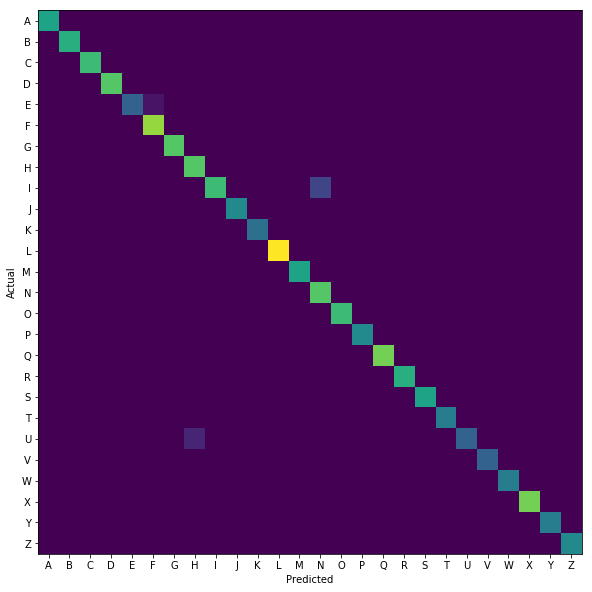

In [339]:
plt.figure(figsize=(10, 10))
plt.imshow(cm)
marking = np.arange(len(letters))
plt.xticks(marking, letters)
plt.yticks(marking, letters)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [340]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The Number of steps required: {0}".format(steps))

The Number of steps required: 1


In [341]:
def compute_distance(prediction, word):
     return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

In [347]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [348]:
num_correct = 0
w = []
a = []
num_incorrect = 0
#print(valid_words)
for word in valid_words:
    correct, word_, prediction = improved_prediction(word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
# print(a)
# print(w)
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 5062
Number incorrect is 451
